# **Time Series Regression Analysis-Corporation Favorita.**

## **1. Business Understanding**
Corporation Favorita currently faces challenges in accurately forecasting sales, leading to stockouts, overstocking, and lost revenue opportunities.<br>The company seeks to leverage its dataset and advanced data manipulation techniques to improve sales predictions and make data-driven decisions.

Following this challenges, the project aims to develop a machine learning model that accurately predicts sales based on time series analysis across various products and stores, enabling the company to optimize inventory management and ensure the right quantity of products are in stock to meet customer demand.

### 1.1. Hypothesis Testing
**Null Hypothesis (Ho):** Promotion has no statistical significant influence on sales<br>

**Alternate Hypothesis (Ha):** Promotion has statistical significant influence on sales

### 1.2. Analytica Questions
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales


## **2. Data Understanding**


### 2.1. Data Collection
### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os

# Libraries for environment variables
from dotenv import dotenv_values
import pyodbc

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

### Load Environment Variables

In [2]:
# Get the current working directory
current_dir = os.getcwd()
# Construct the path to the .env file located in the "env_file" directory
env_path = os.path.join(current_dir, "..", "env_files", ".env")

# Load the .env file
environment_variables = dotenv_values(env_path)
# Access variables from .env file
server = environment_variables.get("SERVER_NAME")
user_name = environment_variables.get("USER_NAME")
password = environment_variables.get("PASSWORD")
database_name = environment_variables.get("DATABSE_NAME")

### Create SQL Server Connection

In [3]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};UID={user_name};DATABASE={database_name};PWD={password}"

# Connect to the server using pyodbc
connection = pyodbc.connect(connection_string)

### 2.2. Load Datasets
We view all the tables present in the database

In [4]:
# SQL query to select all tables from the database
sql_query_table = """
                  SELECT* 
                  FROM INFORMATION_SCHEMA.TABLES
                  WHERE TABLE_TYPE = 'BASE TABLE'
                  """
# Execute the SQL query using pandas read_sql function
tables_in_database = pd.read_sql(sql_query_table, connection)
# Display the resulting table(s) in the database
tables_in_database

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,dapDB,dbo,holidays_events,BASE TABLE
1,dapDB,dbo,oil,BASE TABLE
2,dapDB,dbo,stores,BASE TABLE


In [5]:
# SQL query to select all data from the holidays_events table
sql_query_table_1 = """ SELECT* FROM holidays_events """

# SQL query to select all data from the oil table
sql_query_table_2 = """ SELECT* FROM oil """

# SQL query to select all data from the stores table
sql_query_table_3 = """ SELECT* FROM stores """

In [6]:
# Retrieve tables from the server
holiday_df = pd.read_sql(sql_query_table_1, connection, parse_dates = ["date"])
oil_df = pd.read_sql(sql_query_table_2, connection, parse_dates = ["date"])
stores_df = pd.read_sql(sql_query_table_3, connection)

# Load Training dataset
train_df = pd.read_csv("../data/train.csv", parse_dates = ["date"])
transaction_df = pd.read_csv("../data/transactions.csv", parse_dates = ["date"])

# Load Test dataset
test_df = pd.read_csv("../data/test.csv", parse_dates = ["date"])
sample_submission_df = pd.read_csv("../data/sample_submission.csv")

### 2.3. Exploratory Data Analysis
#### **2.3.1. Holidays_events DataFrame**

- Holidays and Events, with metadata
A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

- For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [7]:
holiday_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [9]:
# Check for null values
holiday_df.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [10]:
print("Unique values for (type):", holiday_df["type"].unique())
print("\nUnique values for (locale):", holiday_df["locale"].unique())
print("\nUnique values for (locale_name):\n", holiday_df["locale_name"].unique())
print("\nUnique values for (transferred):", holiday_df["transferred"].unique())

Unique values for (type): ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']

Unique values for (locale): ['Local' 'Regional' 'National']

Unique values for (locale_name):
 ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']

Unique values for (transferred): [False  True]


In [11]:
holiday_df.duplicated().sum()

np.int64(0)

### Key Notes
- Data Frame has no null values
- Data Frame has no duplicated values
- Data type for transferred column is boolean

#### **2.3.2. Oil DataFrame**
Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

In [12]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [13]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [14]:
# Check for null values
oil_df.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [15]:
# Check for unique values
print("Unique values for (dcoilwtico):\n\n", oil_df["dcoilwtico"].unique()[:30])

Unique values for (dcoilwtico):

 [        nan 93.13999939 92.97000122 93.12000275 93.19999695 93.20999908
 93.08000183 93.80999756 93.59999847 94.26999664 93.26000214 94.27999878
 95.48999786 95.61000061 96.08999634 95.05999756 95.34999847 95.15000153
 95.94999695 97.62000275 97.98000336 97.65000153 97.45999908 96.20999908
 96.68000031 96.44000244 95.83999634 95.70999908 97.01000214 97.48000336]


In [16]:
# Check for duplicated values
oil_df.duplicated().sum()

np.int64(0)

In [17]:
oil_df.describe(include = "all")

,date,dcoilwtico
count,1218,1175.000000
mean,2015-05-02 12:00:00,67.714366
min,2013-01-01 00:00:00,26.190001
25%,2014-03-03 06:00:00,46.405001
50%,2015-05-02 12:00:00,53.189999
75%,2016-06-30 18:00:00,95.660000
max,2017-08-31 00:00:00,110.620003
std,NaN,25.630476


To identify outliers in our dataset, we will use a box plot, which visually highlights the distribution, central tendency, and potential outliers of the data.

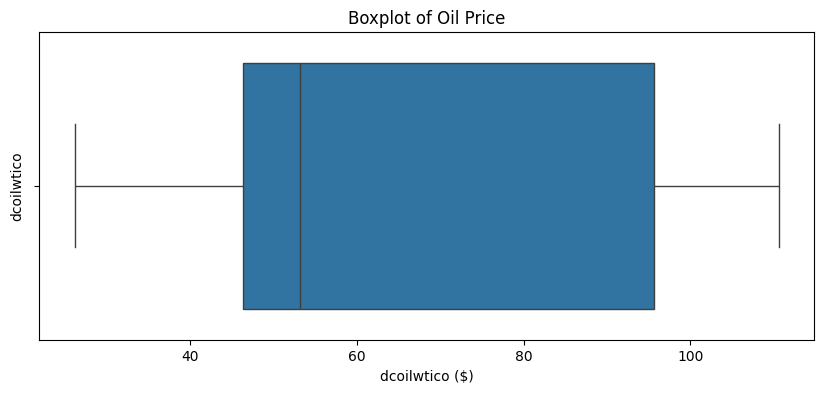

In [18]:
# Set figure size
plt.figure(figsize = (10, 4))

# Plot boxplot
sns.boxplot(data = oil_df, x = "dcoilwtico", orient = "h")

# Set the title and labels
plt.title("Boxplot of Oil Price")
plt.ylabel("dcoilwtico")
plt.xlabel("dcoilwtico ($)")
plt.show()


The box plot indicated no outliers, so we will proceed to use the mean value for our analysis.

In [19]:
# Duplicate "oil_df"
oil_dup_df = oil_df.copy(deep = True)
# Set date as index
oil_dup_df.set_index("date", inplace = True)

# Group mean dcoilwtico by year
oil_data_by_yr = oil_dup_df.resample("Y")["dcoilwtico"].mean()

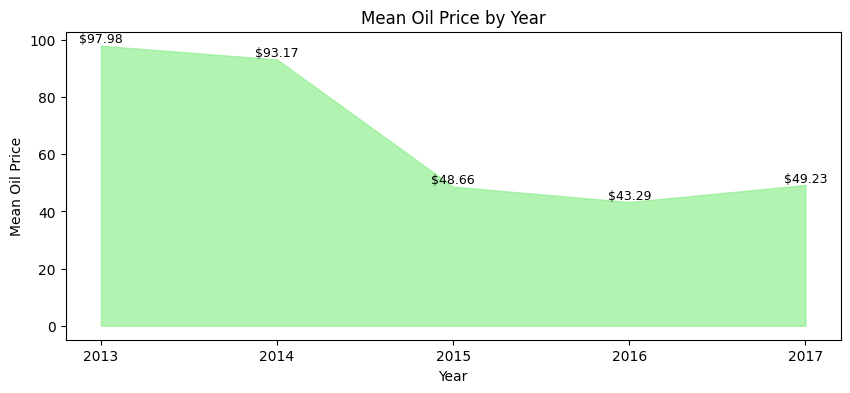

In [20]:
# Set figsize
plt.figure(figsize = (10, 4))

# Plot line chart
plt.fill_between(oil_data_by_yr.index.year, oil_data_by_yr.values, color = "lightgreen", alpha = 0.7)

# Adding data labels
for i, value in enumerate(oil_data_by_yr.values):
    plt.text(oil_data_by_yr.index.year[i], value, f"${round(value, 2)}", ha = "center", va = "bottom", fontsize=9)

# Setting the x-ticks
plt.xticks(oil_data_by_yr.index.year)

# Set the title and labels
plt.title("Mean Oil Price by Year")
plt.ylabel("Mean Oil Price")
plt.xlabel("Year")
plt.show()


### Key Notes
- Data Frame has 43 null values in **"dcoilwtico"** column
- Data Frame has no duplicated values

#### **2.3.3. Stores DataFrame**
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [21]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [22]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [23]:
# Check for null values
stores_df.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [24]:
# Check for duplicated values
stores_df.duplicated().sum()

np.int64(0)

In [25]:
# Check for unique values
print("Unique values for (city):\n", stores_df["city"].unique())
print("\nUnique values for (state):\n", stores_df["state"].unique())
print("\nUnique values for (type):\n", stores_df["type"].unique())

Unique values for (city):
 ['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']

Unique values for (state):
 ['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']

Unique values for (type):
 ['D' 'B' 'C' 'E' 'A']


In [26]:
stores_df.describe(include = "all")

,store_nbr,city,state,type,cluster
count,54.000000,54,54,54,54.000000
unique,NaN,22,16,5,NaN
top,NaN,Quito,Pichincha,D,NaN
freq,NaN,18,19,18,NaN
mean,27.500000,NaN,NaN,NaN,8.481481
std,15.732133,NaN,NaN,NaN,4.693395
min,1.000000,NaN,NaN,NaN,1.000000
25%,14.250000,NaN,NaN,NaN,4.000000
50%,27.500000,NaN,NaN,NaN,8.500000
75%,40.750000,NaN,NaN,NaN,13.000000


#### **2.3.4. Train DataFrame**

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- tore_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [27]:
# Preview dataframe
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [28]:
# Check for data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [29]:
# Chech for null values
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [30]:
# Check for duplicates
train_df.duplicated().sum()

np.int64(0)

In [31]:
train_df.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


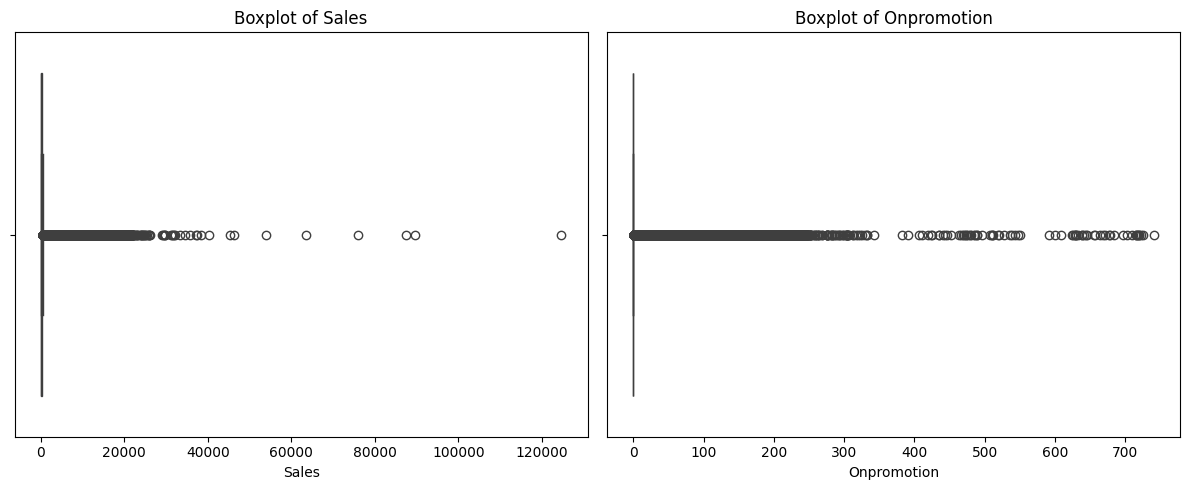

In [32]:
# Create the figure and subplots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5))

# First boxplot for sales
sns.boxplot(data=train_df, x = "sales", ax=axes[0])
axes[0].set_title("Boxplot of Sales")
axes[0].set_xlabel("Sales")

# Second boxplot for onpromotion
sns.boxplot(data=train_df, x = "onpromotion", ax=axes[1])
axes[1].set_title("Boxplot of Onpromotion")
axes[1].set_xlabel("Onpromotion")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [33]:
# Duplicate "train_df"
train_dup_df = train_df.copy(deep = True)
# Set date as index
train_dup_df.set_index("date", inplace = True)

# Group total sales by year
train_data_by_yr = train_dup_df.resample("Y")["sales"].sum()

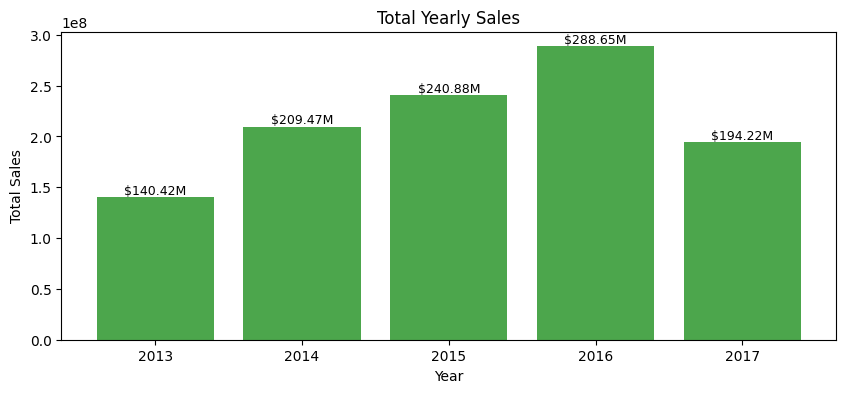

In [34]:
# Set figsize
plt.figure(figsize = (10, 4))

# Plot line chart
plt.bar(train_data_by_yr.index.year, train_data_by_yr.values, color = "green", alpha = 0.7)

# Adding data labels
for i, value in enumerate(train_data_by_yr.values):
    plt.text(train_data_by_yr.index.year[i], value, f"${round(value/10**6, 2)}M", ha = "center", va = "bottom", fontsize=9)

# Setting the x-ticks
plt.xticks(train_data_by_yr.index.year)

# Set the title and labels
plt.title("Total Yearly Sales")
plt.ylabel("Total Sales")
plt.xlabel("Year")
plt.show()


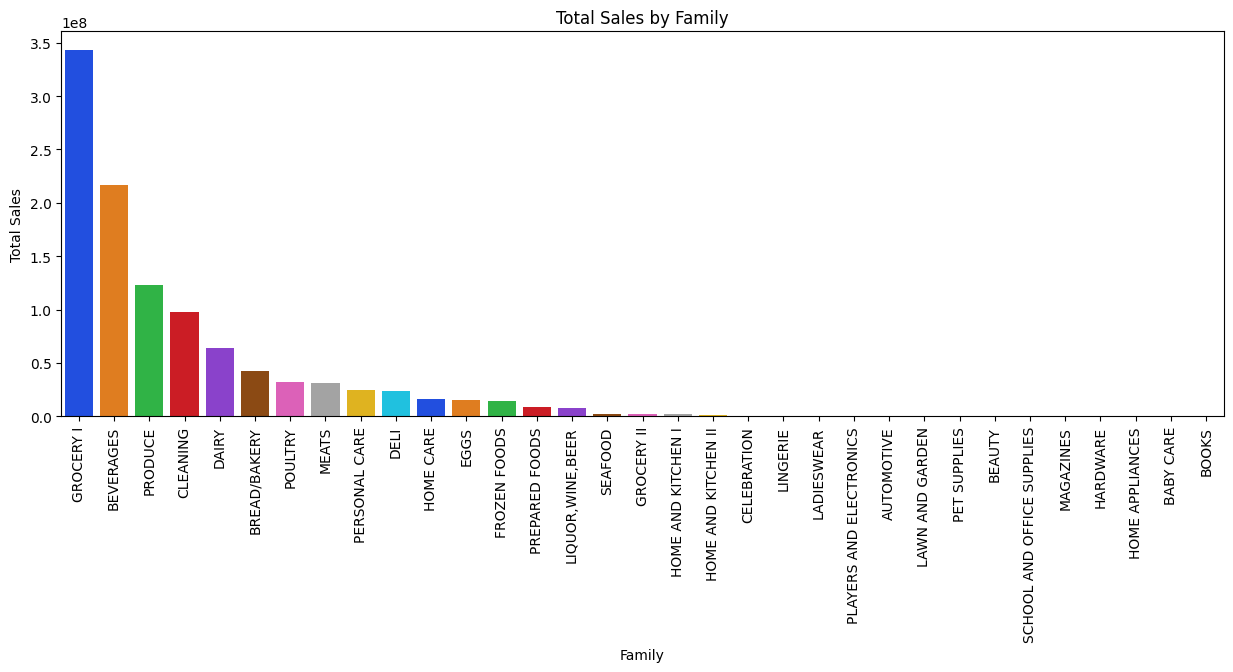

In [35]:
# Create a figure with a specified size
plt.figure(figsize = (15, 5))

# Group the data by 'family', sum up the 'sales', sort in descending order
grouped_data = (train_dup_df
               .groupby("family")
               ["sales"]
               .sum()
               .sort_values(ascending=False)
               )

# Create a bar plot with seaborn using the 'bright' color palette
sns.barplot(grouped_data, palette = "bright")

# Add title and labels to the the plot
plt.title("Total Sales by Family")
plt.xlabel("Family")
plt.ylabel("Total Sales")

# Rotate the x-axis labels by 90 degrees for better readability
plt.xticks(rotation=90)
# Display the plot
plt.show()


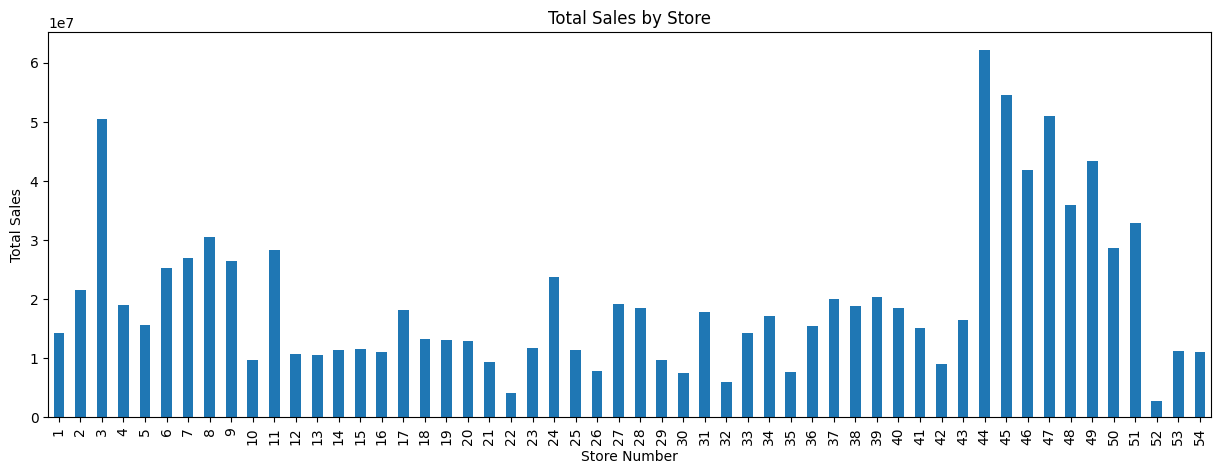

In [36]:
# Create a figure with a specified size
plt.figure(figsize = (15, 5))

# Group sales by store number
(
    train_dup_df
    .groupby("store_nbr")
    ["sales"]
    .sum()
    .plot(kind = "bar")
)

# Add title and labels to the plot
plt.title("Total Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")

# Display the plot
plt.show()


#### **2.3.5. Transaction DataFrame**
Contains date, store_nbr and transaction made on that specific date.

In [37]:
# Preview dataframe
transaction_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [38]:
# Check for data info
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [39]:
# Ceck for null values
transaction_df.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [40]:
# Check for duplicates
transaction_df.duplicated().sum()

np.int64(0)

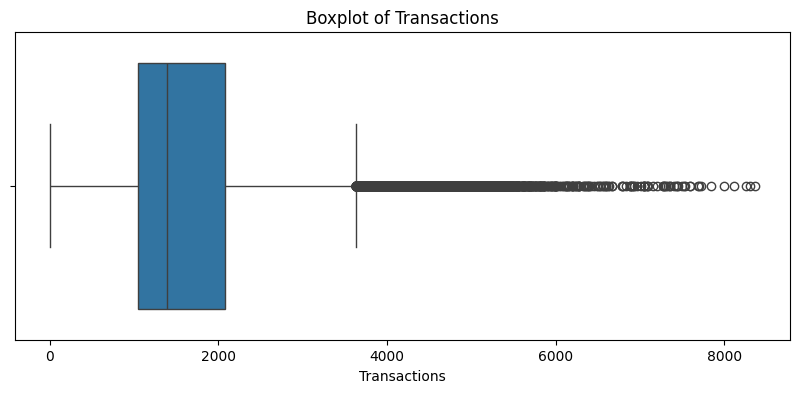

In [41]:
# Set figure size
plt.figure(figsize = (10, 4))

# Plot boxplot
sns.boxplot(data = transaction_df, x = "transactions", orient = "h")

# Set the title and labels
plt.title("Boxplot of Transactions")
plt.xlabel("Transactions")
plt.show()

### **2.4. Check for Stationarity**
Beacuse sales is not normally distributed, we employ the KPSS test (Kwiatkowski-Phillips-Schmidt-Shin test).<br>Unlike the ADF (Augmented Dickey-Fuller) test, which tests for stationarity and assumes non-stationarity as the null hypothesis, the KPSS test assumes stationarity as the null hypothesis.

**Null Hypothesis:** Series is statioary<br>
**Alternate Hypothesis:** Series is not statioary

In [42]:
# Perform the KPSS test
kpss_statistic, p_value, lags, critical_values = kpss(train_dup_df["sales"])

# Print the results
print(f"Test Results:\nTest Statistic: {kpss_statistic}")
print(f"Number of lags: {lags}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")
if p_value < 0.05:
    print("\nCONCLUSION:\nAccording to the KPSS test, the series is not stationary")
else:
    print("\nCONCLUSION:\nAccording to the KPSS test, the series is stationary")

Test Results:
Test Statistic: 147.40710312148062
Number of lags: 695
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

CONCLUSION:
According to the KPSS test, the series is not stationary


### **2.5. Decomposition**
Decomposition is a process of breaking down a time series into its component parts, helping to identify patterns, trends, and seasonality.<br>It's a way to separate a time series into its underlying structures, making it easier to analyze and forecast.

In this analysis, we use decomposition to identify:
- Trend
- Seasonality
- Residuals.


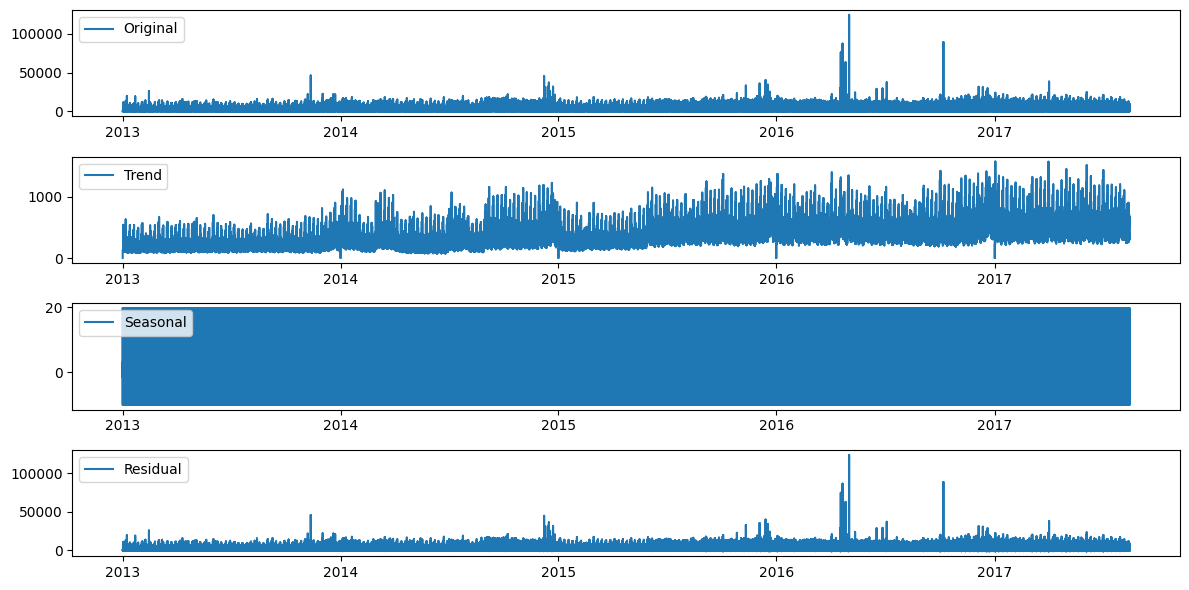

In [43]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(train_dup_df["sales"], model="additive", period=365)

# Plot the components
plt.figure(figsize=(12, 6))

# Original series
plt.subplot(411)
plt.plot(train_dup_df["sales"], label="Original")
plt.legend(loc="upper left")

# Trend component
plt.subplot(412)
plt.plot(decomposition.trend, label="Trend")
plt.legend(loc="upper left")

# Seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, label="Seasonal")
plt.legend(loc="upper left")

# Residual component
plt.subplot(414)
plt.plot(decomposition.resid, label="Residual")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()


### Key Note
- There is trend in sales, and it increases over time.
- The seasonal component appears to be almost constant, indicating that there is no seasonality in sales.
- The residuals indicate that there are some anomalies or irregular fluctuations not explained by the trend and seasonality.

### **2.6. Hypothesis Testing**
**Null Hypothesis (Ho):** Promotion has no statistical significant influence on sales<br>
**Alternate Hypothesis (Ha):** Promotion has statistical significant influence on sales<br>

**Take($\alpha$):** 0.05

In [44]:
# Encode onpromotion column 
train_dup_df["onpromotion_encoded"] = train_dup_df["onpromotion"].apply(lambda x: 1 if x > 0 else 0)

# Extract sales data for promotion and non-promotion groups
sales_promotion = train_dup_df[train_dup_df["onpromotion_encoded"] == 1]["sales"]
sales_non_promotion = train_dup_df[train_dup_df["onpromotion_encoded"] == 0]["sales"]

# Perform the Mann-Whitney U Test
stat, p_value = mannwhitneyu(sales_promotion, sales_non_promotion, alternative = "two-sided")

# Output the results
print(f"Mann-Whitney U Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Promotion has a statistically significant influence on sales.")
else:
    print("Fail to reject the null hypothesis: Promotion does not have a statistically significant influence on sales.")

Mann-Whitney U Test Statistic: 1274034615982.5
P-value: 0.0
Reject the null hypothesis: Promotion has a statistically significant influence on sales.


#### **NB:**<br>At this point, we investigate how promotion influences sales

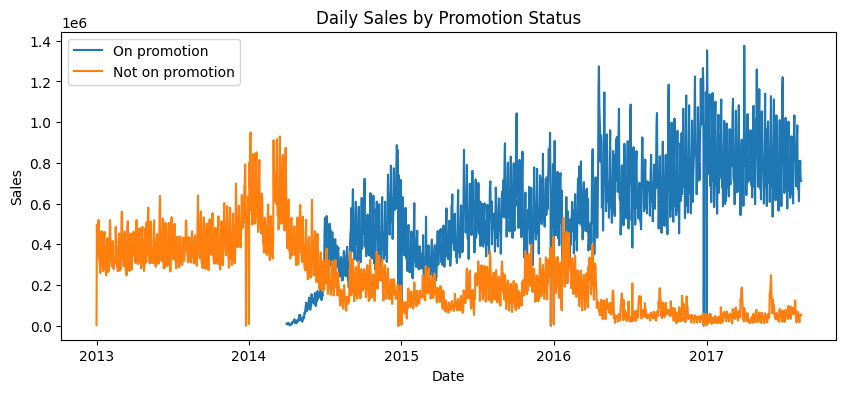

In [45]:
# Set figure size
plt.figure(figsize = (10, 4))

# Plot line chart for daily sales
plt.plot(train_dup_df[train_dup_df["onpromotion_encoded"] == 1].resample("D")["sales"].sum(), label = "On promotion")
plt.plot(train_dup_df[train_dup_df["onpromotion_encoded"] == 0].resample("D")["sales"].sum(), label = "Not on promotion")

# Set the title and labels
plt.title("Daily Sales by Promotion Status")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(loc="upper left")

# Display plot
plt.show()

### Key Insight:<br>
The visualization clearly indicates that promotions have a significant positive impact on sales, leading to higher sales volumes during promotion periods. Additionally, the volatility and spikes during promotions suggest that promotions are effective in driving sales during high-demand periods, but the impact can be temporary.

### **2.7. Analytical Questions**

### 2.7.1. Is the train dataset complete (has all the required dates)?

In [46]:
# check for completeness in train dataset
print(train_df.isna().sum())
print("\nTrain dataset has no null value present")

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Train dataset has no null value present


#### **Check for required dates**

In [47]:
# Check for minimun and maximum dates
min_date, max_date = train_df["date"].min(), train_df["date"].max()

# Get expected number of days between min and max dates
expected_dates = pd.date_range(start = min_date, end = max_date, freq = "D")

# Check if all dates are present in the train dataset
print(f"Expected Number of Dates: {len(expected_dates)}\nNumber of Dates in Train Dataset: {len(train_df['date'].unique())}")
print(f"\nCONCLUSION:\n{len(expected_dates) - len(train_df['date'].unique())} dates are missing")

# Get dates missing from train dataset
missing_dates = list(expected_dates.difference(train_df["date"].unique()))
print(f"\nMissing Dates:\n{missing_dates}")

Expected Number of Dates: 1688
Number of Dates in Train Dataset: 1684

CONCLUSION:
4 dates are missing

Missing Dates:
[Timestamp('2013-12-25 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2016-12-25 00:00:00')]


### Key Insight:
The primary conclusion is that there are specific missing dates in your training dataset, all falling on December 25th across different years indicating store closure due to christmas holiday.

### 2.7.2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

(a) Dates with highest sales for each year

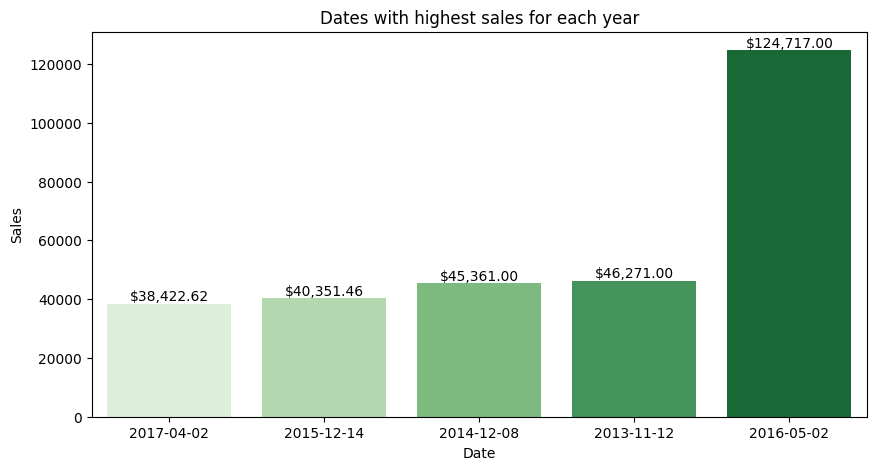

In [48]:
# Reset index
train_dup_df.reset_index(inplace = True)
# Create year column
train_dup_df["year"] = train_dup_df["date"].dt.year
sales_max = train_dup_df.groupby("year")["sales"].idxmax()
rows_max_sales = train_dup_df.loc[sales_max].sort_values(by = "sales", ascending = True)

# Plot a bar chart
plt.figure(figsize=(10,5))
sns.barplot(x = rows_max_sales["date"], y = rows_max_sales["sales"], palette = "Greens")
plt.xlabel("Date")
plt.ylabel("Sales")

# Add labels to the bars
for index, sale in enumerate(rows_max_sales["sales"]):
    label = f"${sale:,.2f}"
    plt.text(index, sale, label, ha = "center", va  = "bottom")
plt.title("Dates with highest sales for each year")
plt.show()

(b) Dates with lowest sales for each year (Excluding days stores were closed)

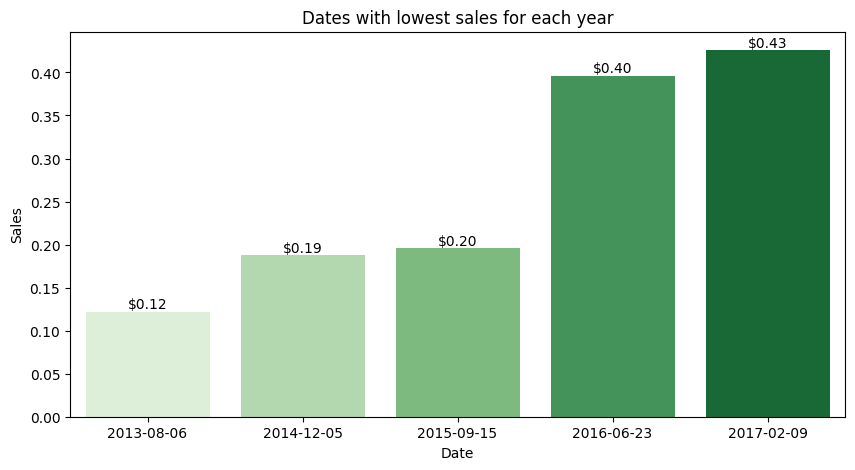

In [49]:
# Filter minimum sales for each year excluding days stores were closed
min_sales_data = train_dup_df[train_dup_df["sales"] > 0]
sales_min = min_sales_data.groupby("year")["sales"].idxmin().sort_values(ascending = True)
rows_min_sales = min_sales_data.loc[sales_min]

# Plot a bar chart
plt.figure(figsize=(10,5))
sns.barplot(x = rows_min_sales["date"], y = rows_min_sales["sales"], palette = "Greens")
plt.xlabel("Date")
plt.ylabel("Sales")

# Add labels to the bars
for index, sale in enumerate(rows_min_sales["sales"]):
    label = f"${sale:,.2f}"
    plt.text(index, sale, label, ha = "center", va  = "bottom")
plt.title("Dates with lowest sales for each year")
plt.show()


### Key Insights
-----

### 2.7.3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

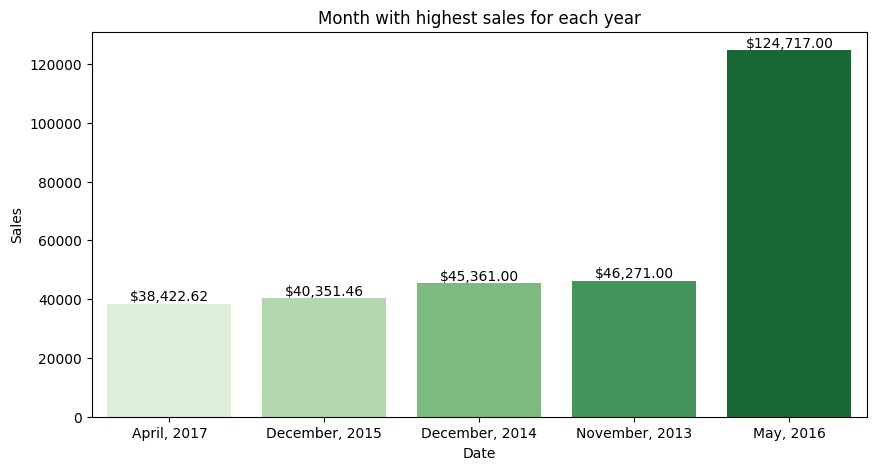

In [50]:
sales_by_yr = (
                    rows_max_sales.groupby(["year", rows_max_sales["date"].dt.month_name()])["sales"]
                    .sum()
                    .sort_values(ascending = True)
                    .rename("sales")
                    .reset_index()
                 )

# Create a Date column comprising of year with corresponding month
sales_by_yr["Date"] = sales_by_yr["date"] + "," + " " + sales_by_yr["year"].astype(str) 
# Plot a bar chart
plt.figure(figsize=(10,5))
sns.barplot(x = sales_by_yr["Date"], y = sales_by_yr["sales"], palette = "Greens")
plt.xlabel("Date")
plt.ylabel("Sales")

# Add labels to the bars
for date, sale in enumerate(sales_by_yr["sales"]):
    plt.text(date, sale, f"${sale:,.2f}", ha = "center", va  = "bottom")
plt.title("Month with highest sales for each year")
plt.show()
# sales_by_yr


### Key Insights
----

### 2.7.4. Did the earthquake impact sales?

On April 16, 2016, a magnitude 7.8 earthquake struck Ecuador, with its epicenter located 50 km west of Rosa Zarate. At this point, we analyse if sales were impacted by the earthquake

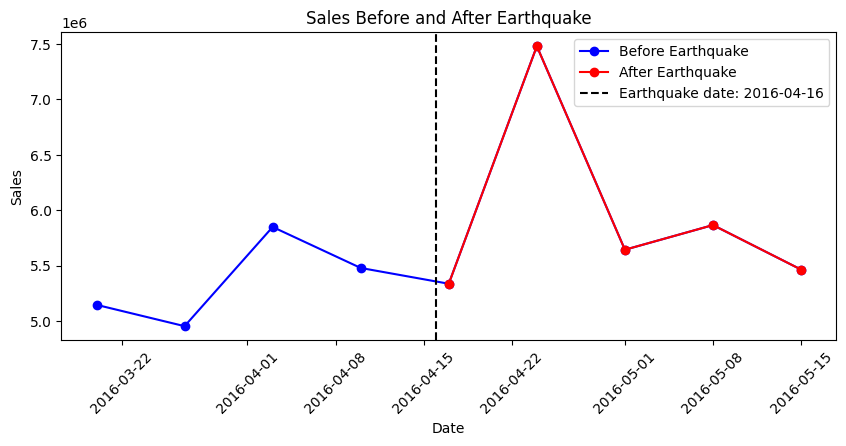

In [51]:
# Set date as index
train_dup_df.set_index("date", inplace = True)

# Resample by week
weekly_sales = train_dup_df.resample("W")["sales"].sum()

# Date before the earthquake
before_earthquake = "2016-03-16"  
# Date of the earthquake
earthquake_date = "2016-04-16" 
# End date 
after_earthquake = "2016-05-16"

# Slice data before and after earthquake
sales_before_earthquake = weekly_sales.loc[before_earthquake:after_earthquake]
sales_after_earthquake = weekly_sales.loc[earthquake_date:after_earthquake]

fig, ax = plt.subplots(figsize = (10, 4))

# Plot before and after earthquake
ax.plot(sales_before_earthquake.index, sales_before_earthquake.values, marker = "o", color = "blue", label = "Before Earthquake")
ax.plot(sales_after_earthquake.index, sales_after_earthquake.values, marker = "o", color = "red", label = "After Earthquake")
ax.axvline(x = pd.to_datetime(earthquake_date), color = "k", linestyle= "--", label = f"Earthquake date: {earthquake_date}")

# Add labels
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_title("Sales Before and After Earthquake")
ax.tick_params(axis = "x", labelrotation = 45)
ax.legend()
plt.show()

### Key Insights
- There is a noticeable spike in sales immediately after the earthquake. This could be attributed to panic buying, stockpiling, or other behavioral changes among consumers in response to the earthquake.
- After the initial spike in sales following the earthquake, sales seem to fluctuate but show an overall declining trend towards the end of the observed period. This might indicate a return to normalcy or a possible drop in consumer demand following the initial post-earthquake spike.

### 2.7.5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

In [52]:
# Merge train and stores dataframe 
train_stores_df = train_dup_df.reset_index().merge(stores_df, how = "left", on = "store_nbr").set_index("date")

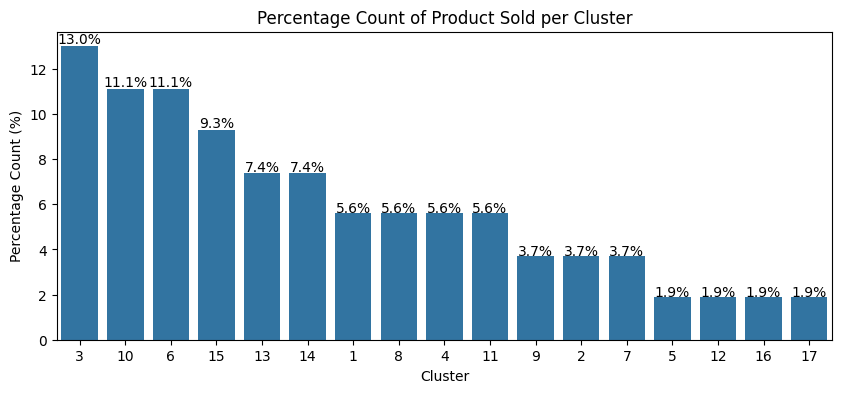

In [53]:
cluster_df = (
    train_stores_df
    .groupby("cluster")["family"]
    .count()
    .sort_values(ascending = False)
    .rename("product_count")
    .reset_index()
)
# Add percentage column
cluster_df["percentage"] = round((cluster_df["product_count"]/cluster_df["product_count"].sum())*100, 1)

# Plot a bar chart
plt.figure(figsize = (10, 4))
sns.barplot(x = cluster_df["cluster"].astype(str), y = cluster_df["percentage"])

# Label title and axis
plt.xlabel("Cluster")
plt.ylabel("Percentage Count (%)")
plt.title("Percentage Count of Product Sold per Cluster")

# Add data point to corresponding bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()
    plt.annotate(f"{height}%", (x + width/2, y + height*1.01), ha = "center")

plt.show()

### Key Insights
------

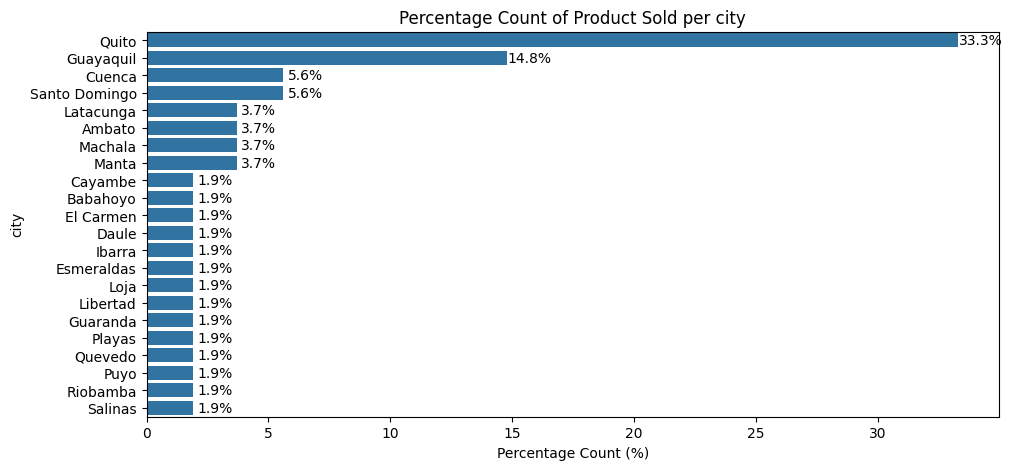

In [54]:
city_df = (
    train_stores_df
    .groupby("city")["family"]
    .count()
    .sort_values(ascending = False)
    .rename("product_count")
    .reset_index()
)
# Add percentage column
city_df["percentage"] = round((city_df["product_count"]/city_df["product_count"].sum())*100, 1)

# Plot a bar chart
plt.figure(figsize = (11, 5))
sns.barplot(x = city_df["percentage"], y = city_df["city"], orient = "h")

# Label title and axis
plt.xlabel("Percentage Count (%)")
plt.ylabel("city")
plt.title("Percentage Count of Product Sold per city")

# Annotate the bars with percentage count
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()        
    plt.annotate(f"{width}%", (x + width + 0.9, y + height*0.8), ha="center")

# Display the plot
plt.show()

### Key Insight
-----

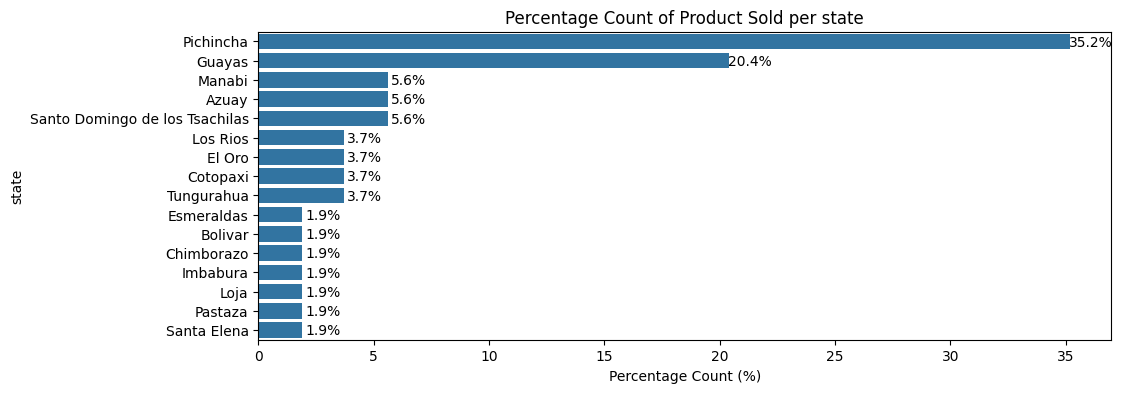

In [55]:
state_df = (
    train_stores_df
    .groupby("state")["family"]
    .count()
    .sort_values(ascending = False)
    .rename("product_count")
    .reset_index()
)
# Add percentage column
state_df["percentage"] = round((state_df["product_count"]/state_df["product_count"].sum())*100, 1)

# Plot a bar chart
plt.figure(figsize = (11, 4))
sns.barplot(x = state_df["percentage"], y = state_df["state"], orient = "h")

# Label title and axis
plt.ylabel("state")
plt.xlabel("Percentage Count (%)")
plt.title("Percentage Count of Product Sold per state")

# Annotate the bars with percentage count
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()        
    plt.annotate(f"{width}%", (x + width + 0.9, y + height*0.8), ha="center")

# Display the plot
plt.show()

### key Insights
----

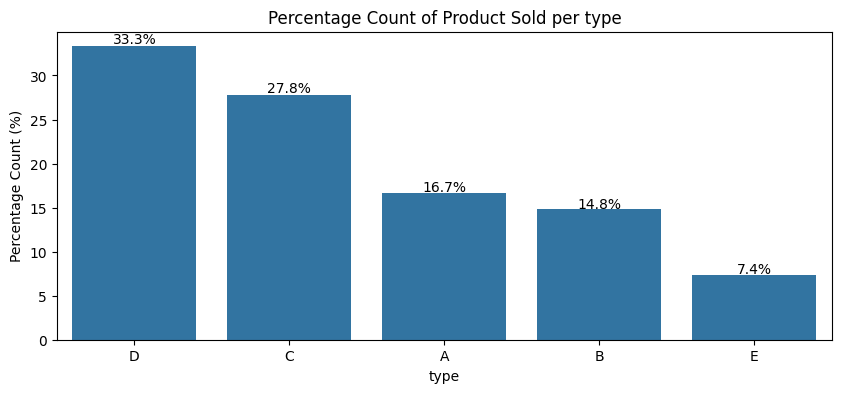

In [56]:
type_df = (
    train_stores_df
    .groupby("type")["family"]
    .count()
    .sort_values(ascending = False)
    .rename("product_count")
    .reset_index()
)
# Add percentage column
type_df["percentage"] = round((type_df["product_count"]/type_df["product_count"].sum())*100, 1)

# Plot a bar chart
plt.figure(figsize = (10, 4))
sns.barplot(x = type_df["type"], y = type_df["percentage"])

# Label title and axis
plt.xlabel("type")
plt.ylabel("Percentage Count (%)")
plt.title("Percentage Count of Product Sold per type")

# Add data point to corresponding bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()
    plt.annotate(f"{height}%", (x + width/2, y + height*1.01), ha = "center")

plt.show()

### Key Insights
---

### 2.7.6. Are sales affected by promotions, oil prices and holidays?<br>
(a) Are sales affected by promotions

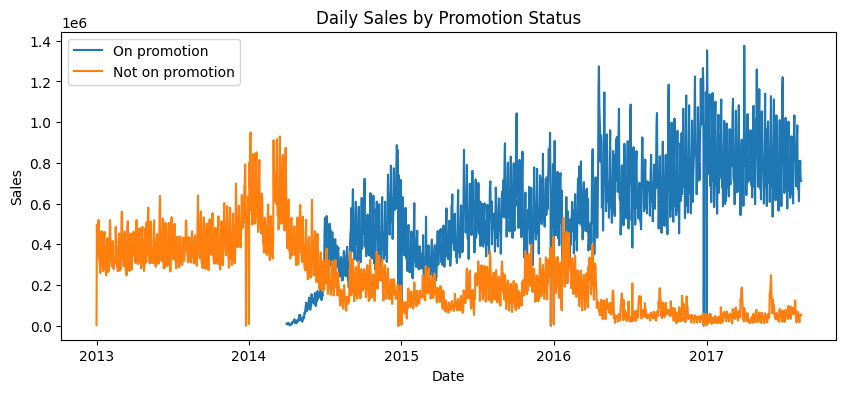

In [57]:
# Set figure size
plt.figure(figsize = (10, 4))

# Plot line chart for daily sales
plt.plot(train_dup_df[train_dup_df["onpromotion_encoded"] == 1].resample("D")["sales"].sum(), label = "On promotion")
plt.plot(train_dup_df[train_dup_df["onpromotion_encoded"] == 0].resample("D")["sales"].sum(), label = "Not on promotion")

# Set the title and labels
plt.title("Daily Sales by Promotion Status")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(loc = "upper left")

# Display plot
plt.show()

### Key Insight:<br>
The visualization clearly indicates that promotions have a significant positive impact on sales, leading to higher sales volumes during promotion periods. Additionally, the volatility and spikes during promotions suggest that promotions are effective in driving sales during high-demand periods, but the impact can be temporary.

(b) Are sales affected by oil prices

In [58]:
# Fill null values in oil data
oil_dup_df["dcoilwtico"] = oil_dup_df["dcoilwtico"].interpolate()

# Merge train and oil dataframe 
train_oil_df = train_dup_df.reset_index().merge(oil_dup_df, how="left", on="date").set_index("date")

# drop null values from the combined oil and train dataframe
train_oil_df = train_oil_df.dropna()

# Calculate the correlation between sales and oil prices
corr, p_value = spearmanr(train_oil_df["sales"], train_oil_df["dcoilwtico"])
print("Spearman correlation: %.2f" % corr)
print("P-value: %.2f" % p_value)


Spearman correlation: -0.18
P-value: 0.00



### Key Insights
- The Spearman correlation coefficient of -0.18 indicates a weak negative relationship between sales and oil prices. This suggests that as oil prices increase, sales tend to decrease slightly, and vice versa. However, the strength of this relationship is quite weak.

- The p-value of 0.00 (or very close to zero) indicates that the correlation is statistically significant. In other words, we can reject the null hypothesis that there is no correlation between sales and oil prices at a significance levels of 0.05.

### Conclusion
Despite the weak correlation, the statistically significant p-value suggests that changes in oil prices do have a small but reliable impact on sales. This weak negative correlation implies that other factors may also play a significant role in influencing sales, and oil prices alone do not explain much of the variation in sales.

(c) Are sales affected by holidays

In [59]:
# Merge train and holiday dataframe 
train_holiday_df = train_dup_df.reset_index().merge(holiday_df, how = "left", on = "date").set_index("date")
train_holiday_df.dropna(inplace = True)

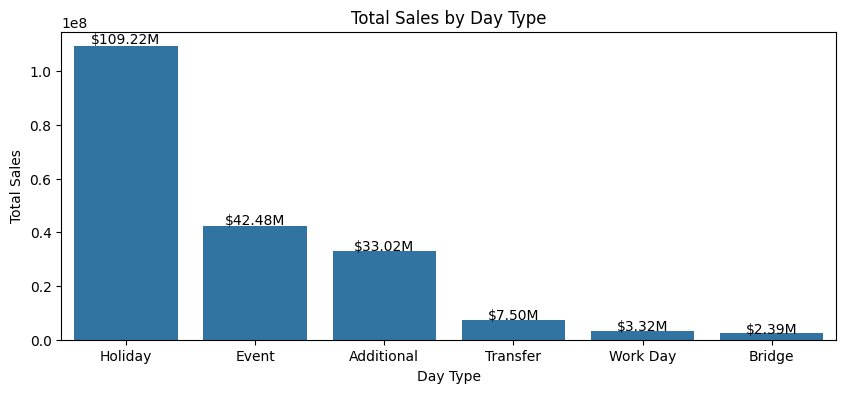

In [60]:
# Group data by day type
sales_day_type = train_holiday_df.groupby("type")["sales"].sum().sort_values(ascending = False)

# Plot bar chart
plt.figure(figsize = (10, 4))
sns.barplot(x = sales_day_type.index, y = sales_day_type.values)
plt.title("Total Sales by Day Type")
plt.xlabel("Day Type")
plt.ylabel("Total Sales")

# Annotate bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()
    plt.annotate(f"${height/10**6:,.2f}M", (x + width/2, y + height*1.01), ha = "center")

plt.show()


### Key Insights
- The bar for holidays shows the highest total sales, reaching approximately $109.22 million. This indicates that holidays significantly boost sales compared to other day types.

- Events and Additional days have substantial total sales of around $42.48 million and $33.02 million, respectively. This suggests that these day types are also associated with higher sales, albeit not as high as holidays.

- Transfer days, Work Days, and Bridge days have much lower total sales, with Transfer days at $7.50 million, Work Days at $3.32 million, and Bridge days at $2.39 million. This indicates that these day types do not contribute as significantly to total sales.

### Conclusion
The significant differences in total sales across different day types highlight that the nature of the day has a considerable impact on sales performance. Holidays have the most substantial impact on total sales, followed by Events and Additional days. Other day types such as Transfer, Work Days, and Bridge days contribute much less to overall sales. This suggests that special days, particularly holidays, are crucial for driving sales and should be a focal point in sales strategies and marketing efforts.

### 2.7.7. What analysis can we get from the date and its extractable features?

At this point, will gain comprehensive insights into the relationship between date-related features and sales, identifying key patterns, trends, and potential areas for further analysis or action.

(a) Sales change over different years

Distribution of Sales by Year: See how sales change over different years.
Monthly Sales Trends: Analyze monthly sales patterns to identify seasonality.
Weekly Sales Trends: Understand how sales vary by day of the week.
Quarterly Sales Analysis: Look at sales trends by quarter.
Holiday vs. Non-Holiday Sales: Compare sales on holidays versus non-holidays

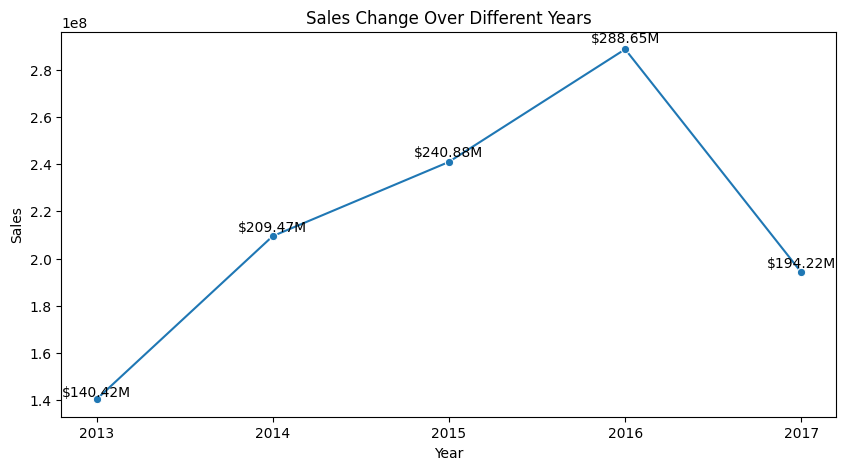

In [61]:
# Set figure size
plt.figure(figsize = (10, 5))

# Plot line chart for sales by year
sns.lineplot(x = train_data_by_yr.index, y = train_data_by_yr.values, marker = "o")

# Set the title and labels
plt.title("Sales Change Over Different Years")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.xticks(ticks = train_data_by_yr.index, labels = train_data_by_yr.index.year)

# Annotate points
for i, point in enumerate(plt.gca().get_lines()[0].get_xydata()):
    year, sales = point
    plt.annotate(f"${sales/10**6:,.2f}M", (year, sales*1.01), ha = "center")

plt.show()

(b) Sales trend by quarter

In [62]:
train_dup_df.reset_index(inplace = True)

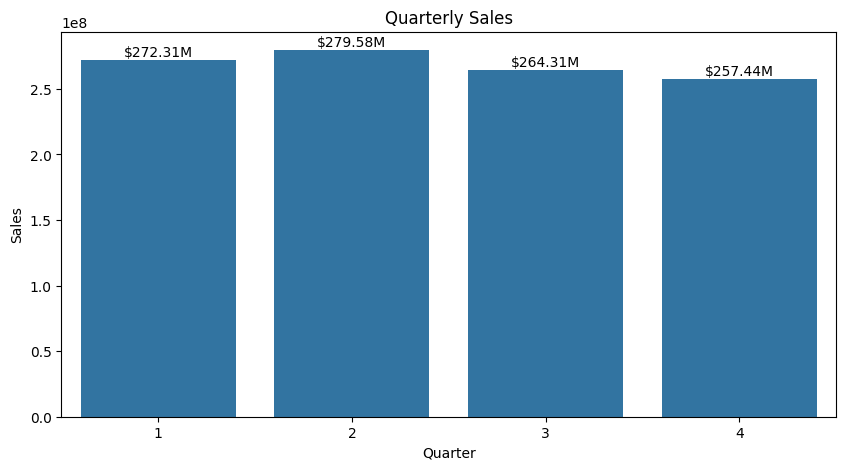

In [63]:
# Add quarter column
train_dup_df["quarter"] = train_dup_df["date"].dt.quarter

# Group sales by quarter
qurtly_sales = train_dup_df.groupby("quarter")["sales"].sum()

# Set figure size
plt.figure(figsize = (10, 5))

# Plot line chart for sales by year
sns.barplot(x = qurtly_sales.index, y = qurtly_sales.values)

# Set the title and labels
plt.title("Quarterly Sales")
plt.xlabel("Quarter")
plt.ylabel("Sales")

# Annotate bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()
    plt.annotate(f"${height/10**6:,.2f}M", (x + width/2, y + height*1.01), ha = "center")

plt.show()

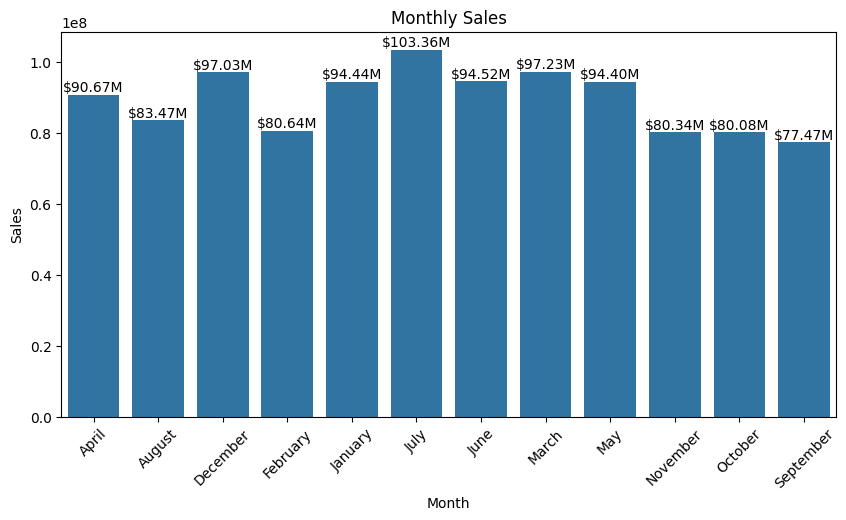

In [64]:
train_dup_df["month"] = train_dup_df["date"].dt.month_name()

# Group sales by month
monthly_sales_df = train_dup_df.groupby("month")["sales"].sum().sort_index()

# Set figure size
plt.figure(figsize = (10, 5))

# Plot line chart for sales by year
sns.barplot(x = monthly_sales_df.index, y = monthly_sales_df.values)

# Set the title and labels
plt.title("Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.tick_params(axis = "x", labelrotation = 45)

# Annotate bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()
    plt.annotate(f"${height/10**6:,.2f}M", (x + width/2, y + height*1.01), ha = "center")

plt.show()

### 2.7.8. Which product family and stores did the promotions affect.

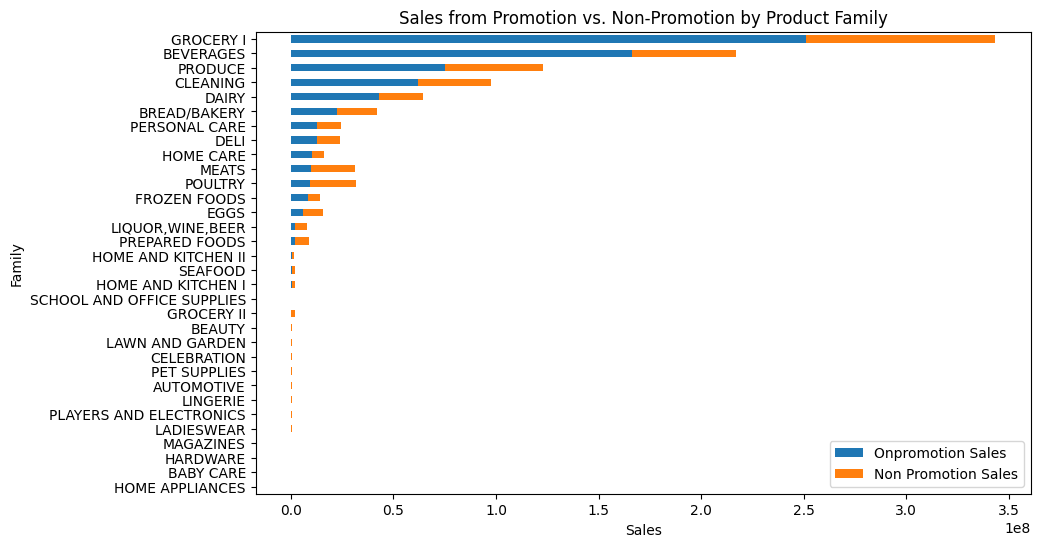

In [65]:
# Filter dataset by promotion status
promotion_df = train_dup_df[train_dup_df["onpromotion_encoded"] == 1]
not_onpromotion_df = train_dup_df[train_dup_df["onpromotion_encoded"] == 0]

# Group promotion and non-promotion data by product family
promotion_sales_by_family = promotion_df.groupby("family")["sales"].sum().sort_values(ascending=True).rename("Onpromotion Sales").reset_index()
not_promotion_sales_by_family = not_onpromotion_df.groupby("family")["sales"].sum().rename("Non Promotion Sales").reset_index()

# Merge the two dataframes on the 'family' column, keeping all product families
combined_df = promotion_sales_by_family.merge(not_promotion_sales_by_family, on="family", how="left")

# Set the 'family' column as the index and create a horizontal stacked bar plot
combined_df.set_index("family").plot(kind="barh", stacked=True, figsize=(10, 6))

# Add title and labels to the plot
plt.title("Sales from Promotion vs. Non-Promotion by Product Family")
plt.xlabel("Sales")
plt.ylabel("Family")

# Show the plot
plt.show()


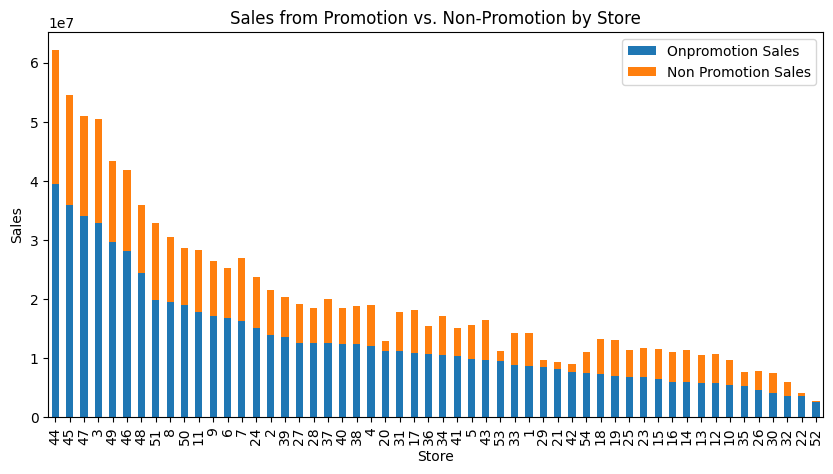

In [66]:
# Filter dataset by promotion status
promotion_df = train_dup_df[train_dup_df["onpromotion_encoded"] == 1]
not_onpromotion_df = train_dup_df[train_dup_df["onpromotion_encoded"] == 0]

# Group promotion and non-promotion data by product store_nbr
promotion_sales_by_store_nbr = promotion_df.groupby("store_nbr")["sales"].sum().sort_values(ascending = False).rename("Onpromotion Sales").reset_index()
not_promotion_sales_by_store_nbr = not_onpromotion_df.groupby("store_nbr")["sales"].sum().rename("Non Promotion Sales").reset_index()

# Merge the two dataframes on the 'store_nbr' column, keeping all product families
combined_store_nbr_df = promotion_sales_by_store_nbr.merge(not_promotion_sales_by_store_nbr, on="store_nbr", how="left")

# Set the 'store_nbr' column as the index and create a horizontal stacked bar plot
combined_store_nbr_df.set_index("store_nbr").plot(kind = "bar", stacked = True, figsize = (10, 5))

# Add title and labels to the plot
plt.title("Sales from Promotion vs. Non-Promotion by Store")
plt.ylabel("Sales")
plt.xlabel("Store")

# Show the plot
plt.show()

### 2.7.9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

- Mean Absolute Error (MAE)<br>

Definition: The average of the absolute differences between predicted and actual values.<br>
Characteristics:<br>
MAE is straightforward to interpret as it represents the average absolute error.
It is less sensitive to outliers compared to MSE and RMSE since it does not square the errors.

- Mean Squared Error (MSE)<br>

Definition: The average of the squared differences between predicted and actual values.<br>
Characteristics:<br>
MSE gives more weight to larger errors due to squaring the differences.
It can be more useful when large errors are particularly undesirable.
However, it is harder to interpret since it is in squared units of the target variable.

- Root Mean Squared Error (RMSE)<br>

Definition: The square root of the average of the squared differences between predicted and actual values.<br>
Characteristics:<br>
RMSE is in the same units as the target variable, making it easier to interpret compared to MSE.
Like MSE, RMSE is more sensitive to outliers due to the squaring of errors.

- Root Mean Squared Logarithmic Error (RMSLE)<br>

Definition: The square root of the average of the squared logarithmic differences between predicted and actual values.<br>
Characteristics:<br>
RMSLE penalizes underestimates more than overestimates.
It is useful when you care more about relative differences than absolute differences.
It is less sensitive to large errors compared to RMSE.

#### Why is MAE Greater Than RMSE, MSE, and RMSLE?<br>

**Sensitivity to Large Errors:**<br>
RMSE and MSE are more sensitive to large errors due to the squaring of the differences. This means that a few large errors will disproportionately increase these metrics compared to MAE.
MAE measures the average error in a linear way, so it does not exaggerate the impact of large errors.

**Units and Interpretation:**<br>
RMSE and MSE can be smaller than MAE if there are significant outliers or large errors because squaring the differences spreads the impact of large errors over the entire dataset.
RMSLE can be smaller than MAE if the dataset has a lot of variation in scale, as it measures the relative difference rather than absolute differences.

**Logarithmic Differences:**<br>
RMSLE uses logarithmic differences, which can reduce the impact of large values and make the errors appear smaller, especially when dealing with exponential growth or when values vary over a large range.
In summary, MAE might be greater than RMSE, MSE, and RMSLE because it does not square the errors, thus not exaggerating the impact of large errors, while the other metrics, especially RMSE and MSE, can show smaller values in the presence of large errors due to the squaring effect. RMSLE's use of logarithmic differences also tends to dampen the impact of large differences, making it potentially smaller than MAE.

### 2.7.10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales

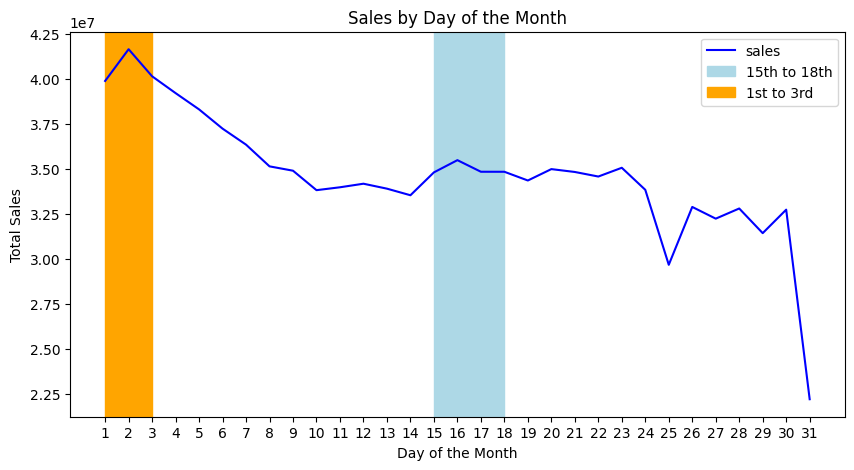

In [67]:
# Sales by day of the month
train_dup_df["day_of_month"] = train_dup_df["date"].dt.day
sales_by_day_month = train_dup_df.groupby("day_of_month")["sales"].sum()
sales_by_day_month.plot(kind = "line", figsize=(10, 5), xlabel = "Day of the Month", ylabel = "Total Sales", title = "Sales by Day of the Month", color= "blue")

# Highlight different periods
plt.axvspan(15, 18, color = "lightblue", label = "15th to 18th")
plt.axvspan(1, 3, color = "orange", label = "1st to 3rd")

plt.xticks(range(1, 32), rotation = "horizontal")
plt.legend(loc = "upper right")
plt.show()

### Key Insights
The data suggests that the payment of wages in the public sector on the 1st and 15th of the month has a significant influence on store sales. Sales increase notably around these dates, indicating that consumers tend to spend more immediately after receiving their wages. This pattern is followed by a decline in sales as the month progresses, especially towards the end of the month.

### **2.8. Differencing**
Differencing is a transformation applied to time series data to make it stationary. Stationarity means that the statistical properties of the time series, such as mean, variance, and autocorrelation, are constant over time. Stationary time series are easier to model and forecast.

Why Differencing is Needed:
- Trend Removal: Time series data often has a trend, which means that the data values increase or decrease over time. Differencing removes this trend, making the series stationary.

- Seasonality Removal: Time series data may also exhibit seasonality, meaning there are regular patterns or cycles over a specific period. Seasonal differencing (e.g., subtracting the value from the same period in the previous cycle) can remove this effect.

- Model Simplification: Many statistical models, like ARIMA (AutoRegressive Integrated Moving Average), require the data to be stationary. Differencing is one way to achieve this.

In [68]:
# Set date as index
train_df = train_df.set_index("date")

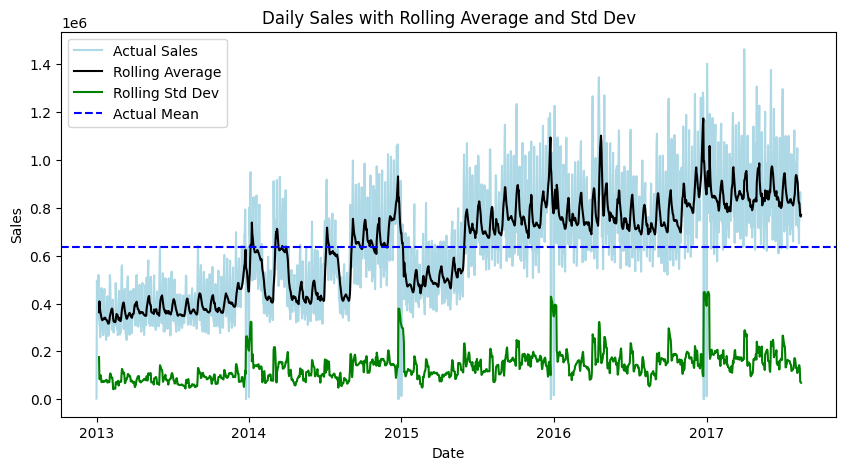

In [69]:
# Calculate mean and standard deviation of sales
train_total_daily_sales = train_df.resample("D")["sales"].sum().rename("sales").reset_index()
mean_sales = train_df["sales"].mean()
std_sales = train_df["sales"].std()

# Plotting
plt.figure(figsize=(10, 5))

# Plot actual sales
plt.plot(train_total_daily_sales["date"], train_total_daily_sales["sales"], label = "Actual Sales", color = "lightblue")
# Plot rolling average
plt.plot(train_total_daily_sales["date"], train_total_daily_sales["sales"].rolling(window = 7).mean(), label = "Rolling Average", color = "black")
# Plot rolling standard deviation
plt.plot(train_total_daily_sales["date"], train_total_daily_sales["sales"].rolling(window = 7).std(), label = "Rolling Std Dev", color = "green")
# Plot actual mean
plt.axhline(y = train_total_daily_sales["sales"].mean(), color = "blue", linestyle = "--", label = "Actual Mean")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Daily Sales with Rolling Average and Std Dev")
plt.legend()
plt.show()

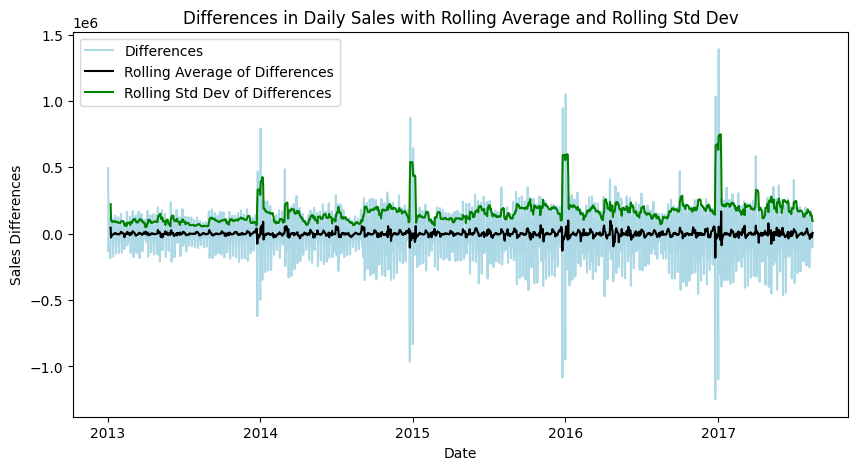

In [70]:
# Calculate differences
sales_difference = train_total_daily_sales["sales"].diff()

# Calculate rolling mean and standard deviation of differences
sales_diff_rolling_average = sales_difference.rolling(window=7).mean()
sales_diff_std = sales_difference.rolling(window=7).std()

# Plotting
plt.figure(figsize=(10, 5))

# Plot differences
plt.plot(train_total_daily_sales["date"], sales_difference, label="Differences", color="lightblue")

# Plot rolling average of differences
plt.plot(train_total_daily_sales["date"], sales_diff_rolling_average, label="Rolling Average of Differences", color="black")

# Plot rolling standard deviation of differences
plt.plot(train_total_daily_sales["date"], sales_diff_std, label="Rolling Std Dev of Differences", color="green")

plt.xlabel("Date")
plt.ylabel("Sales Differences")
plt.title("Differences in Daily Sales with Rolling Average and Rolling Std Dev")
plt.legend()
plt.show()

In [71]:
# Perform the KPSS test
kpss_statistic, p_value, lags, critical_values = kpss(sales_difference.dropna())

# Print the results
print(f"Test Results:\nTest Statistic: {kpss_statistic}")
print(f"Number of lags: {lags}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")
if p_value < 0.05:
    print("\nCONCLUSION:\nAccording to the KPSS test, the series is not stationary")
else:
    print("\nCONCLUSION:\nAccording to the KPSS test, the series is stationary")

Test Results:
Test Statistic: 0.06277531857785063
Number of lags: 54
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

CONCLUSION:
According to the KPSS test, the series is stationary


### Note:
- The actual sales show a clear upward trend over time, indicating that sales are generally increasing.
There are visible seasonal patterns, with peaks and troughs that repeat periodically, likely due to factors like holidays, promotions, or other cyclical events.

- The differenced sales data appears more stationary compared to the original sales data. This is evident as the differenced data fluctuates around a constant mean (close to zero) and exhibits a more consistent variance.

### Conclusion:
- Original Sales Data: Exhibits a clear upward trend and seasonal patterns, with periods of high volatility.

- Differenced Sales Data: Successfully transformed to stationary, with a stable mean and variance, making it more suitable for certain types of time series analysis and modeling.

#### **NB: At this point, we add "sales_difference" and 7-day sales difference to the train_total_daily_sales DataFrame**

In [72]:
# Add the previously calculated sales differences to the DataFrame
train_total_daily_sales["sales_difference"] = sales_difference

# Calculate and add the 7-day difference to the DataFrame
train_total_daily_sales["sales_difference_7"] = (
    train_total_daily_sales["sales"]  # Select the 'sales' column
    .dropna()  # Remove any NaN values
    .diff(7)  # Compute the difference with the value 7 periods earlier
)

# Display the updated DataFrame
train_total_daily_sales.head(3)


,date,sales,sales_difference,sales_difference_7
0,2013-01-01,2511.618999,NaN,NaN
1,2013-01-02,496092.417944,493580.798945,NaN
2,2013-01-03,361461.231124,-134631.186820,NaN


we visualise an autocorrelation plot (also known as a correlogram), to display the autocorrelation of a time series as a function of the lag

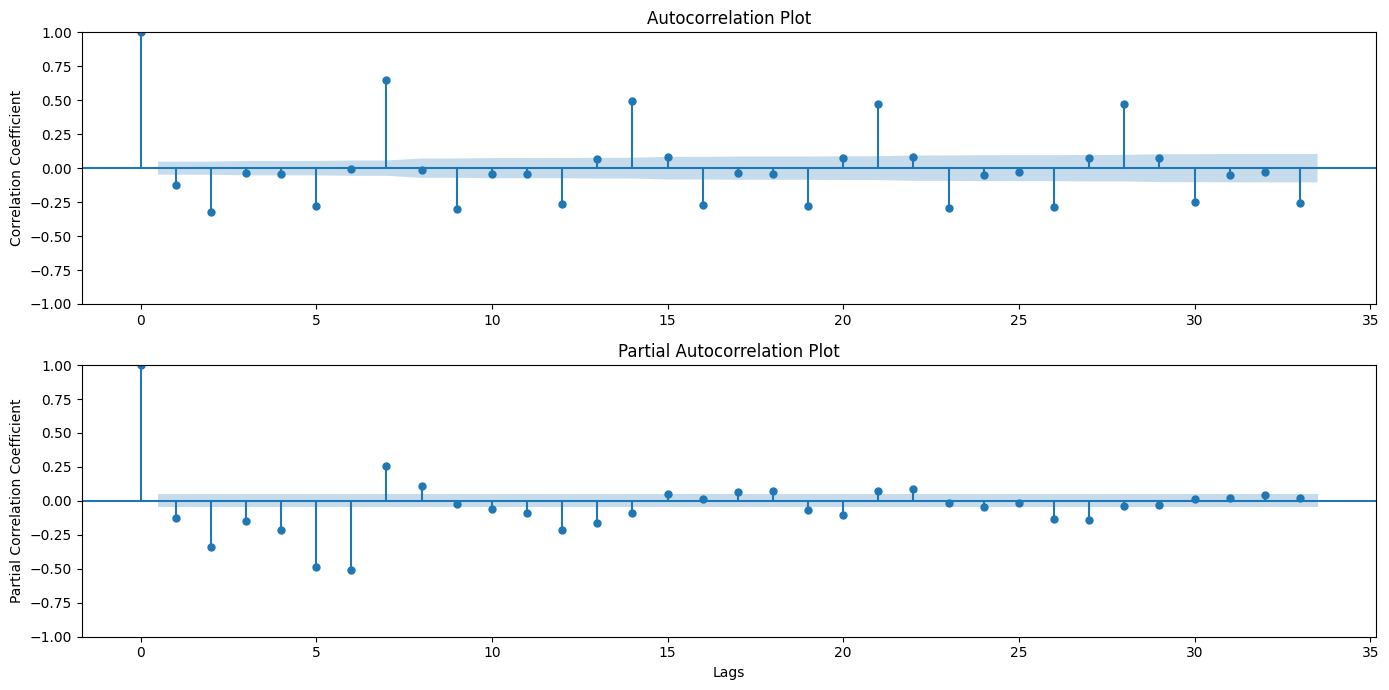

In [73]:
# Plot Autocorrelation Plot
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 7))

# Plot the autocorrelation function with dedicated function
plot_acf(train_total_daily_sales["sales_difference"].dropna(), ax = ax[0])
# Plot the autocorrelation function with dedicated function
plot_pacf(train_total_daily_sales["sales_difference"].dropna(), ax = ax[1])

# Set labels and title for Autocorrelation plot
plt.xlabel("Lags")
ax[0].set_ylabel("Correlation Coefficient")
ax[0].set_title("Autocorrelation Plot")

# Set labels and title for Partial Autocorrelation plot
ax[1].set_ylabel("Partial Correlation Coefficient")
ax[1].set_title("Partial Autocorrelation Plot")

plt.tight_layout()

plt.show()


### Key Insights
- The periodic spikes at regular intervals (every 7 lags) in the ACF plot indicate a clear seasonal pattern. 
- The PACF plot shows significant spikes primarily at lag 1 and smaller spikes at other lags, indicating that the series has short-term dependencies, and the seasonality is primarily captured by the ACF.

#### **NOTE**
Given the clear indication of weekly seasonality, we will employ seasonal ARIMA (SARIMA) model for modelling.

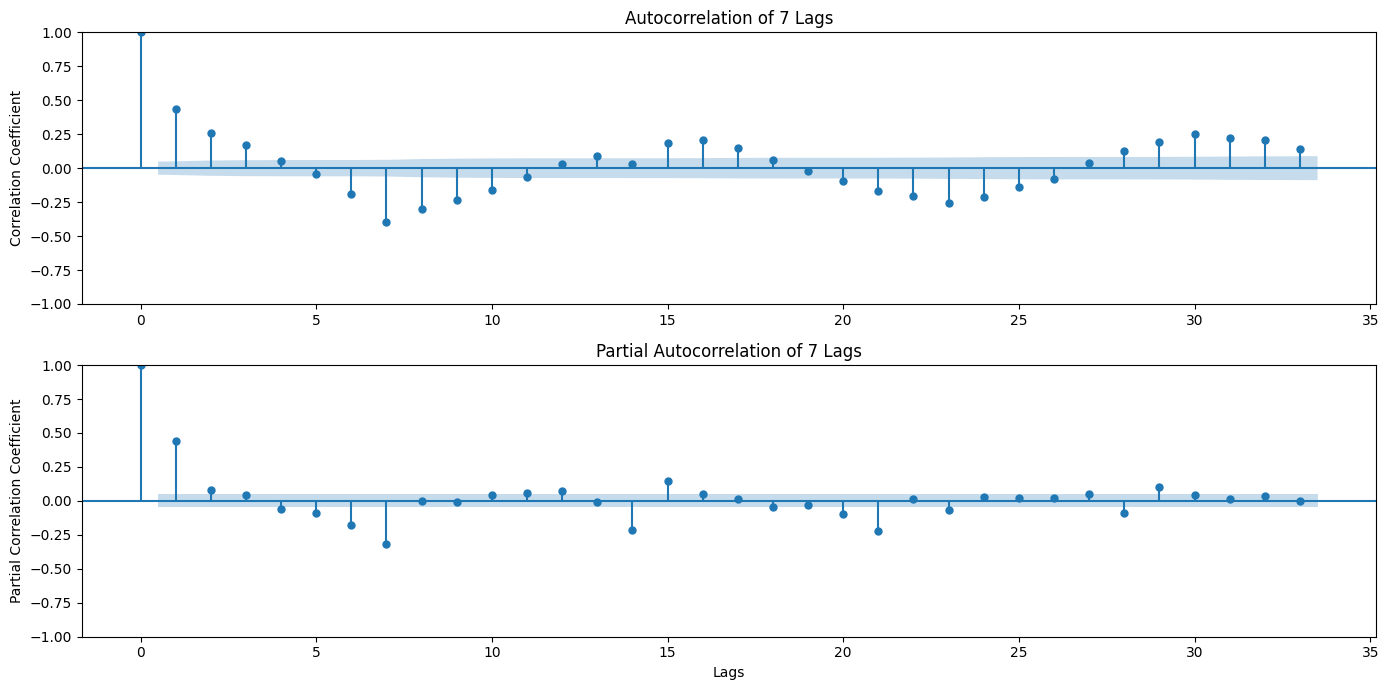

In [74]:
# Plot Autocorrelation Plot
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 7))

# Plot the autocorrelation function with dedicated function
plot_acf(train_total_daily_sales["sales_difference_7"].dropna(), ax = ax[0])
# Plot the partial autocorrelation function with dedicated function
plot_pacf(train_total_daily_sales["sales_difference_7"].dropna(), ax = ax[1])

# Set labels and title for the Autocorrelation plot
plt.xlabel("Lags")
ax[0].set_ylabel("Correlation Coefficient")
ax[0].set_title("Autocorrelation of 7 Lags")

# Set labels and title for the Partial Autocorrelation plot
ax[1].set_ylabel("Partial Correlation Coefficient")
ax[1].set_title("Partial Autocorrelation of 7 Lags")
plt.tight_layout()

plt.show()

### Key Insights
The ACF and PACF plots indicate strong short-term dependencies with diminishing effects after a few lags.

#### **NOTE**
We will employ ARIMA model to capture the data's underlying structure.

### **2.9. Data Preparation**

#### **2.9.1. Handling Missing Values**

In [75]:
# Reset index
train_df.reset_index(inplace = True)

In [76]:
# Convert missing_dates to DataFrame
missing_dates_df = pd.DataFrame(missing_dates).rename(columns = {0: "date"})

# Join missing_dates_df to train_df
complete_train_df = train_df.merge(missing_dates_df, on = "date", how = "outer")
complete_train_df.isna().sum()

date           0
id             4
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

In [77]:
# Fill missing values 
complete_train_df = complete_train_df.interpolate(method = "linear").ffill()
# Check for null values
complete_train_df.isna().sum()

date           0
id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [78]:
# Drop id column
complete_train_df.drop(columns = ["id"], inplace = True)
complete_train_df.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1,2013-01-01,1.0,BABY CARE,0.0,0.0
2,2013-01-01,1.0,BEAUTY,0.0,0.0
3,2013-01-01,1.0,BEVERAGES,0.0,0.0
4,2013-01-01,1.0,BOOKS,0.0,0.0


#### **2.9.2. Data Aggregation**

We will aggregate `complete_train_df` for several reasons including;

1. Data Preparation:
- Consistency: Aggregating ensures that the data is consistent and standardized. For instance, summing sales over a day for each store and product family ensures that each row represents the same time interval.
Missing Data Handling: Aggregating can help fill in gaps or reduce noise in the data, making it easier to handle missing values.

2. Feature Engineering:
- Derived Features: Aggregated data can be used to create new features, such as total sales per day, average sales per store, or the impact of promotions on sales.
Granularity: Machine learning models often require data at a specific granularity (e.g., daily, weekly). Aggregating ensures the data is at the correct level of detail.

3. Reducing Dimensionality:
- Simplifying Data: Aggregating data can reduce the number of rows, which can simplify the modeling process and improve computational efficiency.
Noise Reduction: Summarizing data by aggregating can reduce the effect of outliers and noise, leading to more robust models.

4. Capturing Temporal Patterns:
- Trends and Seasonality: Aggregated data helps capture temporal patterns such as daily, weekly, or monthly trends and seasonality, which are crucial for time series models.
- Lag Features: Aggregating data makes it easier to create lag features, which are essential for time series forecasting.

In [79]:
# Aggregate train data
aggregated_train_df = complete_train_df.groupby(["date", "family", "store_nbr"]).agg({"onpromotion" : "sum", "sales" : "sum"}).reset_index()
aggregated_train_df.head()

,date,family,store_nbr,onpromotion,sales
0,2013-01-01,AUTOMOTIVE,1.0,0.0,0.0
1,2013-01-01,AUTOMOTIVE,2.0,0.0,0.0
2,2013-01-01,AUTOMOTIVE,3.0,0.0,0.0
3,2013-01-01,AUTOMOTIVE,4.0,0.0,0.0
4,2013-01-01,AUTOMOTIVE,5.0,0.0,0.0


#### **2.9.3. Feature Engineering**

In [80]:
# Extract year end
aggregated_train_df["year_end"] = (aggregated_train_df["date"].dt.is_year_end).replace({True: "Yes", False: "No"})

# Extract day of week
aggregated_train_df["day_of_week"] = aggregated_train_df["date"].dt.day_of_week

# Extract Pay data: 15th of the month and last day of the month
aggregated_train_df["is_payday"] = np.where((aggregated_train_df["date"].dt.day == 15) | (aggregated_train_df["date"].dt.is_month_end), "Yes", "No")

In [81]:
# Set date column as index
aggregated_train_df.set_index("date", inplace = True)

# Preview dataframe
aggregated_train_df.head()

,family,store_nbr,onpromotion,sales,year_end,day_of_week,is_payday
date,,,,,,,
2013-01-01,AUTOMOTIVE,1.0,0.0,0.0,No,1,No
2013-01-01,AUTOMOTIVE,2.0,0.0,0.0,No,1,No
2013-01-01,AUTOMOTIVE,3.0,0.0,0.0,No,1,No
2013-01-01,AUTOMOTIVE,4.0,0.0,0.0,No,1,No
2013-01-01,AUTOMOTIVE,5.0,0.0,0.0,No,1,No


In [82]:
print(pd.DataFrame({"dataframe_info": aggregated_train_df.info(), "null_value_count": aggregated_train_df.isna().sum()}))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000892 entries, 2013-01-01 to 2017-08-15
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   family       object 
 1   store_nbr    float64
 2   onpromotion  float64
 3   sales        float64
 4   year_end     object 
 5   day_of_week  int32  
 6   is_payday    object 
dtypes: float64(3), int32(1), object(3)
memory usage: 171.7+ MB
            dataframe_info  null_value_count
family                None                 0
store_nbr             None                 0
onpromotion           None                 0
sales                 None                 0
year_end              None                 0
day_of_week           None                 0
is_payday             None                 0


#### Split data into X and y 

In [83]:
# Perform the train test split based on the time series order
start = "2017-01-01"
y = aggregated_train_df["sales"]
X = aggregated_train_df.drop("sales", axis = 1)

X_train, X_eval, y_train, y_eval = X.loc[X.index < start], X.loc[X.index >= start], y.loc[y.index < start], y.loc[y.index >= start]

In [84]:
# Get split data shapes
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape

((2596378, 6), (404514, 6), (2596378,), (404514,))

#### Group X dataset by categorical features and numerical features

In [85]:
# Select column names with numerical features
numerical_features = list(X_train.select_dtypes("number").columns)
# Select column names with categorical features
categorical_features = list(X_train.select_dtypes("object").columns)

#### Prepare Pipeline

In [86]:
# Create numerical pipeline
num_pipeline = Pipeline(steps = [("Scaler", RobustScaler())])

# Create categorical pipeline
cat_pipeline = Pipeline(steps = [("Encoder", OneHotEncoder(handle_unknown = "ignore"))])

# Combine Transformers using columntransformer
processor = ColumnTransformer(transformers = [("Numeric", num_pipeline, numerical_features),
                                              ("Categoric", cat_pipeline, categorical_features)])

# Create full pipeline
full_pipeline = Pipeline(steps = [("Preocessor", processor)])

In [87]:
# Transform splitted data with pipeline
X_train_transformed = full_pipeline.fit_transform(X_train)
X_eval_transformed = full_pipeline.transform(X_eval)

## **3. Machine Learning Modelling**

At this point, we aim to develop and evaluate multiple models to accurately forecast sales in a time series context. Leveraging historical data, we will implement and compare the performance of four distinct models:
- ARIMA (AutoRegressive Integrated Moving Average)
- SARIMA (Seasonal AutoRegressive Integrated Moving Average)
- Linear Regression
- XGBoost.
- GradientBoost Regressor

By exploring and contrasting the strengths and limitations of each model, we seek to identify the most effective solution for predicting future sales informed decision-making.

#### **Splitting data for ARIMA and SARIMA models**

In [88]:
train_total_daily_sales.set_index("date", inplace = True)

# Split the data into train and test
train = train_total_daily_sales.loc[train_total_daily_sales.index < "2017-01-01"]
test = train_total_daily_sales.loc[train_total_daily_sales.index >= "2017-01-01"]

#### **3.1. ARIMA MODEL**

In [89]:
# Create and fit the ARIMA model
arima_model = ARIMA(train["sales_difference_7"].dropna(), order = (0, 1, 0))
arima_model_fit = arima_model.fit()

# Make predictions
arima_pred_difference = arima_model_fit.predict(start = len(train), end = int(len(train) + len(test) - 1))

# Replace negative values with 0
arima_pred_difference = np.where(arima_pred_difference < 0, 0, arima_pred_difference)
arima_sales_difference_eval = np.where(test["sales_difference_7"] < 0, 0, test["sales_difference_7"])

#### **3.2. SARIMA MODEL**

In [90]:
# Create and fit the SARIMA model
sarima_model = SARIMAX(train["sales_difference"].dropna(), order = (0, 1, 0), seasonal_order = (0, 1, 0, 7))
sarima_model_fit = sarima_model.fit()

# Make predictions
sarima_pred_difference = sarima_model_fit.predict(start = len(train), end = int(len(train) + len(test) - 1))

# Replace negative values with 0
sarima_pred_difference = np.where(sarima_pred_difference < 0, 0, sarima_pred_difference)
sarima_sales_difference_eval = np.where(test["sales_difference"] < 0, 0, test["sales_difference"])


#### **3.3. LINEAR REGRESSION MODEL**

In [91]:
# Initialise model
lr_model = LinearRegression()

# Fit the model to the training data
lr_model.fit(X_train_transformed, y_train)

# Make predictions on the evaluation data
lr_predictions = lr_model.predict(X_eval_transformed)
# Replace any negative value with 0
lr_predictions = np.maximum(lr_predictions, 0)

#### **3.4. XGBOOST MODEL**

In [92]:
# Initialise model
xgb_model = XGBRegressor(random_state = 42, n_estimators = 100, n_jobs = -1, objective = "reg:squarederror", eval_metric = "mae")

# Fit the model to the training data
xgb_model.fit(X_train_transformed, y_train)

# Make predictions on the evaluation data
xgb_predictions = xgb_model.predict(X_eval_transformed)
# Replace any negative value with 0
xgb_predictions = np.maximum(xgb_predictions, 0)

#### **3.5. GRADIENT BOOSTING REGRESSOR MODEL**

In [93]:
# Initialize model
gbr_model = GradientBoostingRegressor(n_estimators = 100, random_state = 0)

# Fit model to training data
gbr_model.fit(X_train_transformed, y_train)

# Make predictions on the evaluation data
gbr_predictions = gbr_model.predict(X_eval_transformed)
# Replace any negative value with 0
gbr_predictions = np.maximum(gbr_predictions, 0)

## **Model Evaluation**

In [94]:
#  Calculate the metrics
arima_r2 = r2_score(arima_sales_difference_eval, arima_pred_difference)
sarima_r2 = r2_score(sarima_sales_difference_eval, sarima_pred_difference)
lr_r2 = r2_score(y_eval, lr_predictions)
xgb_r2 = r2_score(y_eval, xgb_predictions)
gbr_r2 = r2_score(y_eval, gbr_predictions)

arima_mae = mean_absolute_error(arima_sales_difference_eval, arima_pred_difference)
sarima_mae = mean_absolute_error(sarima_sales_difference_eval, sarima_pred_difference)
lr_mae = mean_absolute_error(y_eval, lr_predictions)
xgb_mae = mean_absolute_error(y_eval, xgb_predictions)
gbr_mae = mean_absolute_error(y_eval, gbr_predictions)

arima_rmse = np.sqrt(mean_squared_error(arima_sales_difference_eval, arima_pred_difference))
sarima_rmse = np.sqrt(mean_squared_error(sarima_sales_difference_eval, sarima_pred_difference))
lr_rmse = np.sqrt(mean_squared_error(y_eval, lr_predictions))
xgb_rmse = np.sqrt(mean_squared_error(y_eval, xgb_predictions))
gbr_rmse = np.sqrt(mean_squared_error(y_eval, gbr_predictions))

arima_rmsle = np.sqrt(mean_squared_log_error(arima_sales_difference_eval, arima_pred_difference))
sarima_rmsle = np.sqrt(mean_squared_log_error(sarima_sales_difference_eval, sarima_pred_difference))
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval, lr_predictions))
xgb_rmsle = np.sqrt(mean_squared_log_error(y_eval, xgb_predictions))
gbr_rmsle = np.sqrt(mean_squared_log_error(y_eval, gbr_predictions))

# Create a DataFrame to hold the metrics
evalution_metrics = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "Linear Regression", "XGBoost Regressor", "GradientBoosting Regressor"],
    "R-SQUARED": [arima_r2, sarima_r2, lr_r2, xgb_r2, gbr_r2],
    "MAE": [arima_mae, sarima_mae, lr_mae, xgb_mae, gbr_mae],
    "RMSE": [arima_rmse, sarima_rmse, lr_rmse, xgb_rmse, gbr_rmse],
    "RMSLE": [arima_rmsle, sarima_rmsle, lr_rmsle, xgb_rmsle, gbr_rmsle]
})

evalution_metrics

,Model,R-SQUARED,MAE,RMSE,RMSLE
0,ARIMA,-0.199338,50891.817492,124831.373159,7.367624
1,SARIMA,-3.879133,164828.399410,290017.651433,8.545687
2,Linear Regression,0.582444,267.811654,875.703783,1.753928
3,XGBoost Regressor,0.921941,117.007370,378.626154,1.443347
4,GradientBoosting Regressor,0.785586,237.863369,627.519055,1.951435


### Key Insights

Based on the performance metrics, XGBoost Regressor significantly outperforms other models for this dataset. It has the highest R-squared value of 0.921941, indicating a strong fit to the data, and the lowest error metrics `(MAE: 117.007370, RMSE: 378.626154, RMSLE: 1.443347)`. This suggests that XGBoost Regressor is the most effective model for predicting the target variable in this analysis.<br>In contrast, the ARIMA and SARIMA models perform poorly, as indicated by a negative R-squared values and very high error metrics, making them unsuitable for this dataset.

## **Hyperparameter Tuning**

Given that the XGB Regressor is our top-performing model, we will use RandomizedGridSearch to fine-tune its hyperparameters to enhance its performance.


In [95]:
# Define parameter grid
xgb_param_grid = {"n_estimators": [100, 200, 300],
                  "learning_rate": [0.01, 0.05, 0.1],
                  "max_depth": [3, 4, 5],
                  "subsample": [0.5, 0.7, 0.9],
                  "gamma": [0, 0.1, 0.2],
                  "alpha": [0, 0.1, 0.2]}

# Initialize RandomizedSearchCV 
xgb_random_search = RandomizedSearchCV(xgb_model,
                                       param_distributions = xgb_param_grid,
                                       cv = 5,
                                       random_state = 42,
                                       n_jobs = -1)

# Fit the model to the training data
xgb_random_search.fit(X_train_transformed, y_train)

# Get best parameters
best_params = xgb_random_search.best_params_

# Print best parameters
best_params

Parameters for XGBoost Regressor: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'lambda': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7, 'alpha': 0}


In [111]:
# Initialize the xgb regressor with the best parameters
xgb_tuned_model = XGBRegressor(**best_params)

# Fit the tuned model to the training data
xgb_tuned_model.fit(X_train_transformed, y_train)

# Make predictions on the evaluation data
xgb_tuned_predictions = xgb_tuned_model.predict(X_eval_transformed)

# Replace any negative value with 0
xgb_tuned_predictions = np.maximum(xgb_tuned_predictions, 0)

# Calculate the metrics
xgb_tuned_r2 = r2_score(y_eval, xgb_tuned_predictions)
xgb_tuned_mae = mean_absolute_error(y_eval, xgb_tuned_predictions)
xgb_tuned_rmse = np.sqrt(mean_squared_error(y_eval, xgb_tuned_predictions))
xgb_tuned_rmsle = np.sqrt(mean_squared_log_error(y_eval, xgb_tuned_predictions))

# Create a DataFrame to hold the metrics
tuned_evaluation_metrics = pd.DataFrame({"Model": ["XGBoost Regressor (Tuned)"],
                                         "R-SQUARED": [xgb_tuned_r2],
                                         "MAE": [xgb_tuned_mae],
                                         "RMSE": [xgb_tuned_rmse],
                                         "RMSLE": [xgb_tuned_rmsle]})

In [114]:
# Filter the original evaluation metrics to only include the "XGBoost Regressor"
untuned_evaluation_metrics = evalution_metrics[evalution_metrics["Model"] == "XGBoost Regressor"][["Model", "R-SQUARED", "MAE", "RMSE", "RMSLE"]]

# Compare evaluation matrices of tuned and untuned xgb regressor
compare_evaluation_metrics = pd.concat([untuned_evaluation_metrics, tuned_evaluation_metrics], join = "outer", axis = 0, ignore_index = True)
compare_evaluation_metrics

,Model,R-SQUARED,MAE,RMSE,RMSLE
0,XGBoost Regressor,0.921941,117.007370,378.626154,1.443347
1,XGBoost Regressor (Tuned),0.837569,200.139379,546.178194,1.745073


### Key Insight
From this comparison, it is clear that the untuned XGBoost Regressor outperforms its tuned version.<br>The untuned XGBoost Regressor remains the best choice for predicting sales in this dataset, given its superior performance across all evaluation metrics.

### **Prepare Unseen Data**

In [115]:
# Preview dataframe
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [116]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


**Note:**
DataFrame has no null values so we go ahead to aggregate and perfrom feature engineering

In [119]:
# Aggregate train data
aggregated_test_df = test_df.groupby(["date", "family", "store_nbr"]).agg({"onpromotion" : "sum"}).reset_index()
aggregated_test_df.head()

,date,family,store_nbr,onpromotion
0,2017-08-16,AUTOMOTIVE,1,0
1,2017-08-16,AUTOMOTIVE,2,0
2,2017-08-16,AUTOMOTIVE,3,0
3,2017-08-16,AUTOMOTIVE,4,0
4,2017-08-16,AUTOMOTIVE,5,0


In [120]:
# Extract year end
aggregated_test_df["year_end"] = (aggregated_test_df["date"].dt.is_year_end).replace({True: "Yes", False: "No"})

# Extract day of week
aggregated_test_df["day_of_week"] = aggregated_test_df["date"].dt.day_of_week

# Extract Pay data: 15th of the month and last day of the month
aggregated_test_df["is_payday"] = np.where((aggregated_test_df["date"].dt.day == 15) | (aggregated_test_df["date"].dt.is_month_end), "Yes", "No")

In [121]:
# Set date column as index
aggregated_test_df.set_index("date", inplace = True)

# Preview dataframe
aggregated_test_df.head()

,family,store_nbr,onpromotion,year_end,day_of_week,is_payday
date,,,,,,
2017-08-16,AUTOMOTIVE,1,0,No,2,No
2017-08-16,AUTOMOTIVE,2,0,No,2,No
2017-08-16,AUTOMOTIVE,3,0,No,2,No
2017-08-16,AUTOMOTIVE,4,0,No,2,No
2017-08-16,AUTOMOTIVE,5,0,No,2,No


### **Make Predictions on Prepared Data**

In [125]:
# Transform Test Dataframe with full pipeline
test_transformed = full_pipeline.transform(aggregated_test_df)

# Predict sales using untuned xgboost model
xgb_predictions_test = xgb_model.predict(test_transformed)
# Replace negative values with 0
xgb_predictions_test = np.where(xgb_predictions_test < 0, 0, xgb_predictions_test)

# Add predicted sales to original data
test_df["sales"] = pd.Series(xgb_predictions_test)

# Sample outcome
test_df.sample(10)

## Save Model